## Inspiration : https://www.youtube.com/watch?v=9sHcLvVXsns&t=0s

In [1]:
#load everything
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torchvision.utils import make_grid

import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import os

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
impath = 'archive8000/Images'

cappath = "archive8000/captions.txt"

In [3]:
# !pip install -U spacy

In [4]:
# !python -m spacy download en_core_web_sm

-----------------------------------------
## Learning what is spacy
- In dataset loading I might need the tutorial for it ;-;

In [5]:
# python -m spacy download en_core_web_sm
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [6]:
text = ("When Sebastian Thrun started working on self-driving cars at "
        "Google in 2007, few people outside of the company took him "
        "seriously. “I can tell you very senior CEOs of major American "
        "car companies would shake my hand and turn away because I wasn’t "
        "worth talking to,” said Thrun, in an interview with Recode earlier "
        "this week.")
doc = nlp(text)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Noun phrases: ['Sebastian Thrun', 'self-driving cars', 'Google', 'few people', 'the company', 'him', 'I', 'you', 'very senior CEOs', 'major American car companies', 'my hand', 'I', 'Thrun', 'an interview', 'Recode']
Verbs: ['start', 'work', 'drive', 'take', 'tell', 'shake', 'turn', 'talk', 'say']
Sebastian Thrun PERSON
Google ORG
2007 DATE
American NORP
Thrun PERSON
Recode ORG
earlier this week DATE


- End learinng 
----------------------------

In [35]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in nlp.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

In [36]:
annotation =pd.read_csv(cappath)
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [37]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="../input/flickr8kimagescaptions/flickr8k/images", caption_path="../input/flickr8kimagescaptions/flickr8k/captions.txt", freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pd.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [38]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets

In [39]:
transform = transforms.Compose(
        [
            transforms.Resize((72, 72)),
            transforms.RandomCrop((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [40]:
def get_loader(root_dir=impath, caption_path=cappath, transform=transform):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=12, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [41]:
loader, dataset = get_loader()

10000


In [42]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 64, 64]), torch.Size([21]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([     1, 108926, 108564, 108917, 108700, 108899, 108150, 108151, 108564,
        101321, 108919,  87058, 108926, 107551,  98191, 108922, 108272, 107686,
        102420, 108925,      2])
<SOS> a man is looking on as another man attempts to climb a small boulder with his dirt bike . <EOS> 

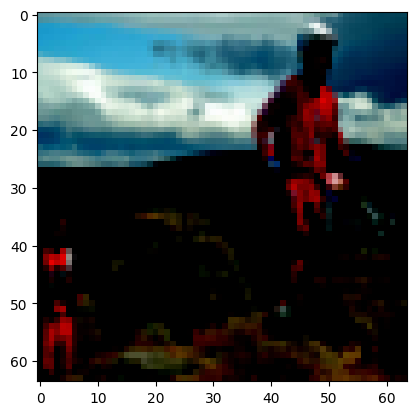

In [43]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [44]:
from tqdm import tqdm
import torchvision.models as models


In [45]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model=False
train_CNN = False

In [46]:
# new_model = models.inception_v3(weights='default')
# new_model.fc

In [47]:
# res = models.resnet18(weights='DEFAULT' , progress = True)

In [48]:
import torch.optim as optim 

step = 0
embed_size = 64
hidden_size = 64
num_layers = 5
num_epochs = 5
learning_rate = 3e-4
vocab_size = len(dataset.vocab)

In [49]:
class encoderCNN(nn.Module):
    def __init__(self, embed_size, should_train=False):
        super(encoderCNN, self).__init__()
        self.should_train = should_train
        self.inception = models.resnet18(weights='DEFAULT' , progress = True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.dropout= nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        features = self.inception(x)
        
        for name, param in self.inception.named_parameters():
            param.requires_grad = False
        
        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.required_grad = self.should_train
        
        
        return self.dropout(self.relu(features))

In [50]:
class decoderRNN(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(decoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, caption):
        # print(caption)
        embeddings = self.dropout(self.embedding(caption))
        # print(embeddings)
        # raise
        embeddings = torch.cat((features.unsqueeze(0),embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [51]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(embed_size)
        self.decoderRNN = decoderRNN(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x
    
    def captionImage(self, image, vocabulary, maxlength=50):
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(image)#.unsqueeze(0)
            states = None
            
            for _ in range(maxlength):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                # print(output)
                predicted = output.argmax()
                # print(predicted.shape)
                result_caption.append(predicted.item())
                # output= torch.tensor(output).to(torch.int64)
                # TODO
                # x = self.decoderRNN.embedding(output).unsqueeze(0)#[t.numpy() for t in my_list_of_tensors]
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        return [vocabulary.itos[i] for i in result_caption]

In [52]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

In [53]:
model.decoderRNN

decoderRNN(
  (embedding): Embedding(108931, 64)
  (lstm): LSTM(64, 64, num_layers=5)
  (linear): Linear(in_features=64, out_features=108931, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [54]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [55]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [56]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [60]:
model.train()

for epoch in range(num_epochs):
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": model.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

#     for idx, (imgs, captions) in tqdm(
#         enumerate(loader), total=len(loader), leave=False
#     ):
    for idx, (imgs, captions) in enumerate(loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        score = model(imgs, captions[:-1])
        
#         print(score.shape, captions.shape)
#         print(score.reshape(-1, score.shape[2]).shape, captions.reshape(-1).shape)
#         print("why are we reshaping it here?")
        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))
        
       
        step += 1
        
        loss.backward()
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


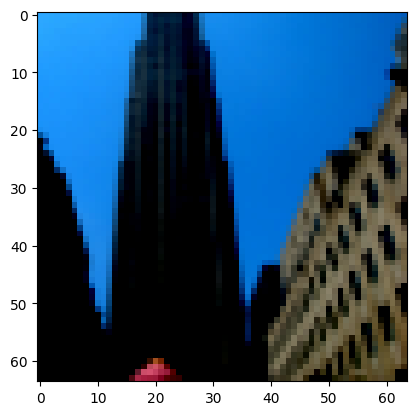

In [61]:
image_path = "archive8000/images/1032460886_4a598ed535.jpg"

img = Image.open(image_path)

img = transform(img)

# print(img.unsqueeze(0).shape)
plt.imshow(img.permute(1,2,0))
# img.size()
# raise
image_input = img.unsqueeze(0).to(device=device) # check here

print(model.captionImage(image=image_input, vocabulary=dataset.vocab))

In [ ]:
# print(output)

In [ ]:
example = torch.tensor([ 0.0792,  0.0924,  0.0506, -0.1295,  0.0586,  0.0550],
       device='cuda:0')

In [ ]:
example.argmax()

tensor(1, device='cuda:0')

In [ ]:
tryemb = nn.Embedding(vocab_size, embed_size)




In [ ]:
exnoncu = torch.tensor([ 0.0792,  0.0924,  0.0506, -0.1295,  0.0586,  0.0550])

In [ ]:
tryemb(exnoncu)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)